<a href="https://colab.research.google.com/github/varunxsensei/Comment-Toxicity-DeepNN/blob/main/Comment_Toxicity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
import os

In [ ]:
import tensorflow as tf
print("GPU available:", tf.config.list_physical_devices('GPU'))


GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
np.expand_dims??

In [ ]:
df = pd.read_csv("comment-tox-train.csv")

In [ ]:
df.head(2)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0


In [ ]:
df.shape

(159571, 8)

In [ ]:
df.tail(2)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


In [ ]:
df.iloc[2]["comment_text"]

"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."

In [ ]:
df[df.columns[2:]].iloc[6]

,6
toxic,1
severe_toxic,1
obscene,1
threat,0
insult,1
identity_hate,0


In [ ]:
# df.iloc[6]['comment_text']

In [ ]:
from tensorflow.keras.layers import TextVectorization

In [ ]:
X = df['comment_text']

In [ ]:
y= df.iloc[:,2:].values

In [ ]:
MAX_FEATURES = 200000 # No of words in vocab

In [ ]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_mode='int',
                               output_sequence_length=1800)

In [ ]:
vectorizer.adapt(X.values)

In [ ]:
# vectorizer.get_vocabulary()[3976]

In [ ]:
# vectorizer("Today's day is sunny")[:4]

In [ ]:
vectorized_text = vectorizer(X.values)

In [ ]:
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]])>

**Data preparation**

In [ ]:
# MACSHBAP -> Map,Cache,Shuffle,Batch,Prefetch
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text,y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [ ]:
batch_x,batch_y = dataset.as_numpy_iterator().next()

In [ ]:
batch_x.shape

(16, 1800)

In [ ]:
train = dataset.take(int(len(dataset)*.7))

In [ ]:
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [ ]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 1800), dtype=tf.int64, name=None), TensorSpec(shape=(None, 6), dtype=tf.int64, name=None))>

In [ ]:
val

<_TakeDataset element_spec=(TensorSpec(shape=(None, 1800), dtype=tf.int64, name=None), TensorSpec(shape=(None, 6), dtype=tf.int64, name=None))>

In [ ]:
test

<_TakeDataset element_spec=(TensorSpec(shape=(None, 1800), dtype=tf.int64, name=None), TensorSpec(shape=(None, 6), dtype=tf.int64, name=None))>

**Creating Dense Layer**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dropout,Bidirectional,Dense,Embedding

In [ ]:
model = Sequential()
# First layer is gonna be embedding layer
model.add(Embedding(MAX_FEATURES+1,32, input_shape=(1800,)))
model.add(Bidirectional(LSTM(32,activation='tanh')))
model.add(Dense(128,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(6,activation='sigmoid'))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(loss = "BinaryCrossentropy",optimizer="Adam")

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 1800, 32)       │     6,400,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,491,686 (24.76 MB)

 Trainable params: 6,491,686 (24.76 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(train,epochs=5,validation_data=val,verbose=1)

Epoch 1/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 753s 107ms/step - loss: 0.0825 - val_loss: 0.0451
Epoch 2/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 727s 104ms/step - loss: 0.0464 - val_loss: 0.0409
Epoch 3/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 728s 104ms/step - loss: 0.0420 - val_loss: 0.0360
Epoch 4/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 729s 104ms/step - loss: 0.0362 - val_loss: 0.0312
Epoch 5/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 756s 108ms/step - loss: 0.0327 - val_loss: 0.0289


In [ ]:
history.history

{'loss': [0.06123685836791992,
  0.04585588350892067,
  0.04138647019863129,
  0.036368872970342636,
  0.032735828310251236],
 'val_loss': [0.045134562999010086,
  0.040852345526218414,
  0.036001306027173996,
  0.03123815730214119,
  0.028908217325806618]}

<Figure size 1200x700 with 0 Axes>

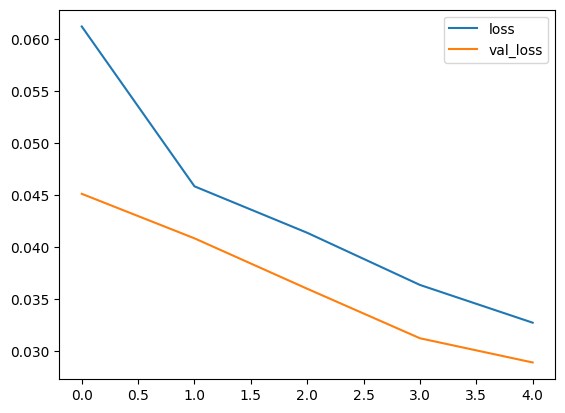

In [ ]:
plt.figure(figsize = (12,7))
pd.DataFrame(history.history).plot()
plt.show()

In [ ]:
# making predictions

In [ ]:
input_text = vectorizer("you are dead")

In [ ]:
model.predict(np.expand_dims(input_text,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


array([[0.5924873 , 0.00162553, 0.05316524, 0.01323655, 0.13627942,
        0.02883234]], dtype=float32)

In [ ]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    # Unpack the batch
    X_true, y_true = batch
    # Make a prediction
    yhat = model.predict(X_true)

    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()

    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━

In [ ]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8732301592826843, Recall:0.8090298771858215, Accuracy:0.5356068015098572


In [ ]:
!pip install gradio jinja2

In [ ]:
import tensorflow as tf
import gradio as gr

In [ ]:
model.save('toxicity.h5')

In [ ]:
model = tf.keras.models.load_model('toxicity.h5')

In [ ]:
input_str = vectorizer('hey i freaken hate you!')

In [ ]:

res = model.predict(np.expand_dims(input_str,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


In [ ]:
res

array([[0.7903588 , 0.00324994, 0.05733145, 0.02109702, 0.31948784,
        0.0523909 ]], dtype=float32)

In [ ]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)

    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)

    return text

In [ ]:
interface = gr.Interface(
    fn=score_comment,
    inputs=gr.Textbox(lines=2, placeholder='Comment to score', label="Input Comment"),
    outputs=gr.Text(label="Toxicity Score")
)

In [ ]:
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://14b24514c1ab723a43.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
